# fine-mapping

In [1]:
## Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioinfokit import visuz
from matplotlib_venn import venn3, venn3_unweighted
import myvariant
%matplotlib inline

## Data Preprocessing

In [ ]:
# Load the summary statistics
df = pd.read_csv("input/IGAP_stage_1.txt", header=0, sep='\t')

# Add the column of ZScores = Beta / SE
df['Zscore'] = df['Beta'] / df['SE']

# Add the empty column of minor allele frequency
df['MAF'] = ''

# Reorder the columns
cols = df.columns.tolist()
cols = cols[:3] + [cols[-1]] + cols[3:-1]
df = df[cols]

# Output the dataset in the required form
h = ['CHR', 'BP', 'rsID', 'MAF', 'EA', 'NEA', 'BETA', 'SE', 'P', 'Zscore']
df.to_csv('input/summary.txt', sep='\t', header=h, index=False)

In [1]:
# Input sample sizes
sample_size = 17008 + 37154
sample_size

54162

## Commands used to run the programs

In [ ]:
%%bash
# download programs
cd bin
./00_set_up.sh

# Compute LD and build the reference panel
cd ../ref
mkdir ./ld/vcf
cp /datasets/cs284-sp21-A00-public/1000Genomes/*.gz ./ld/vcf
cp /datasets/cs284-sp21-A00-public/1000Genomes/*.tbi ./ld/vcf
nohup python 01_prepare_reference.py &

# Run fine-mapping tools
cd ..
nohup python fine_map_pipe.py -s 54162 input/summary.txt output &
mv nohup.out def_param_nohup.out
mv output/summary_total_credible_set.txt output/def_param_tot_cred_set.txt

# Run fine-mapping tools with diff params
nohup python fine_map_pipe.py -s 54162 -n 2 input/summary.txt output &
mv nohup.out n_2_nohup.out
mv output/summary_total_credible_set.txt output/n_2_tot_cred_set.txt

## Process the results

In [38]:
## Extact the executation time from the nohup outputs
def extract_exec_time(logs):
    ''' Extract the executation time printed in the nohup log file '''
    exec_time = {'PAINTOR': 0, 'CAVIARBF': 0, 'FINEMAP': 0}
    with open(logs, 'r') as infile:
        for line in infile:
            if line.startswith('---'):
                _, prog, _, _, time, _ = line.strip().split()
                exec_time[prog] += int(time[:-1])
    return exec_time

In [7]:
exec_time = extract_exec_time("output/def_param_nohup.out")
print("Execution time: PAINTOR = {} s, CAVIARBF = {} s, FINEMAP = {} s\n".format(*exec_time.values()))

# Use FINEMAP runtime as a reference
print("Relative exec time: PAINTOR = {}, CAVIARBF = {}, FINEMAP = {}".format(*np.array(list(exec_time.values()))/exec_time['FINEMAP']))

Execution time: PAINTOR = 1094 s, CAVIARBF = 810 s, FINEMAP = 335 s

Relative exec time: PAINTOR = 3.265671641791045, CAVIARBF = 2.417910447761194, FINEMAP = 1.0


In [42]:
exec_time2 = extract_exec_time("output/nohup.out")
print("Execution time: PAINTOR = {} s, CAVIARBF = {} s, FINEMAP = {} s\n".format(*exec_time2.values()))
print("Relative exec time: PAINTOR = {}, CAVIARBF = {}, FINEMAP = {}".format(*np.array(list(exec_time2.values()))/exec_time2['FINEMAP']))

Execution time: PAINTOR = 196240 s, CAVIARBF = 2372 s, FINEMAP = 1427 s

Relative exec time: PAINTOR = 137.51927119831814, CAVIARBF = 1.662228451296426, FINEMAP = 1.0


In [15]:
## Load the final results (credible sets)
res = pd.read_csv("output/def_param_tot_cred_set.txt", sep='\t', header=0)
res = res.sort_values(['FINEMAP'], ascending=False)
res.rename(columns={'BP':'POS','EA':'REF','NEA':'ALT'}, inplace=True)
res['cred_set'] = -1
print(res.shape)
res.head(10)

(6684, 16)


,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,-1
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,-1
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,-1
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,-1
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,-1
15,2,127892810,rs6733839,0.3797,T,C,0.1880,0.0176,1.659000e-26,10.681818,0.504097,0.504220,0.504194,207,7,-1
16,2,127891427,rs4663105,0.4036,C,A,0.1837,0.0172,1.001000e-26,10.680233,0.495903,0.495779,0.495806,207,7,-1
6675,19,1063443,rs4147929,0.1849,A,G,0.1348,0.0224,1.701000e-09,-6.017857,0.380885,0.392008,0.389905,1580,7,-1
312,7,143099133,rs10808026,0.2227,A,C,-0.1393,0.0206,1.417000e-11,-6.762136,0.342352,0.348517,0.347266,832,7,-1
326,11,60103385,rs72924659,0.2942,T,C,-0.1413,0.0196,5.354000e-13,-7.209184,0.326261,0.345285,0.341369,1129,7,-1


In [16]:
## update the credible set assignments
markers = []
for i in range(blocks.shape[0]):
    chr_, start, stop = blocks.iloc[i]
    # print()
    res_sel = res[(res['CHR'] == chr_) & (res['POS'] >= start) & (res['POS'] <= stop)].sort_values(['FINEMAP'], ascending=False)
    res.loc[(res['CHR'] == chr_) & (res['POS'] >= start) & (res['POS'] <= stop), ['cred_set']] = i+1
    # res_sel
    marker = res_sel.iloc[0]['rsID']
    # print(marker)
    markers.append(marker)

In [17]:
res.head(10)

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,13
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,11
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,9
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,8
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,10
15,2,127892810,rs6733839,0.3797,T,C,0.1880,0.0176,1.659000e-26,10.681818,0.504097,0.504220,0.504194,207,7,2
16,2,127891427,rs4663105,0.4036,C,A,0.1837,0.0172,1.001000e-26,10.680233,0.495903,0.495779,0.495806,207,7,2
6675,19,1063443,rs4147929,0.1849,A,G,0.1348,0.0224,1.701000e-09,-6.017857,0.380885,0.392008,0.389905,1580,7,12
312,7,143099133,rs10808026,0.2227,A,C,-0.1393,0.0206,1.417000e-11,-6.762136,0.342352,0.348517,0.347266,832,7,5
326,11,60103385,rs72924659,0.2942,T,C,-0.1413,0.0196,5.354000e-13,-7.209184,0.326261,0.345285,0.341369,1129,7,7


In [18]:
## load the summary statistics
df = pd.read_csv("input/summary.txt", sep='\t')
df['P'] = df['P'] + 1e-100
df.head(10)

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore
0,1,751343,rs28544273,NaN,A,T,-0.0146,0.0338,0.6651,-0.431953
1,1,751756,rs143225517,NaN,C,T,-0.0146,0.0338,0.6651,-0.431953
2,1,752566,rs3094315,NaN,G,A,-0.0122,0.0294,0.6773,-0.414966
3,1,753405,rs61770173,NaN,C,A,-0.0126,0.0339,0.7104,-0.371681
4,1,768253,rs2977608,NaN,A,C,-0.0394,0.0261,0.1308,-1.509579
5,1,768448,rs77786510,NaN,A,G,-0.0385,0.0303,0.2034,-1.270627
6,1,769963,rs7518545,NaN,A,G,-0.0471,0.0360,0.1904,-1.308333
7,1,845274,rs112856858,NaN,T,G,0.0234,0.0329,0.4766,0.711246
8,1,845635,rs117086422,NaN,T,C,0.0317,0.0303,0.2944,1.046205
9,1,845938,rs57760052,NaN,A,G,0.0307,0.0295,0.2967,1.040678


In [4]:
## load identified causal blocks
blocks = pd.read_csv("output/summary_significant_blocks.txt", sep='\t', header=0)
print(blocks.shape)
blocks

(13, 3)


,chr,start,stop
0,1,206073265,208410364
1,2,127373764,128034347
2,6,31571218,32682664
3,6,47311898,48391125
4,7,142656310,144968289
5,8,26682525,28162392
6,11,58780549,62223771
7,11,84381272,86619301
8,11,121175943,122591910
9,14,91296860,93132299


In [19]:
## Set a lower bound for p-values for visualization purpose
df.loc[df['P'] <= 1e-30, ['P']] = 1e-30
df['P'].min()

1e-30

In [259]:
# Manhattan plot
# visuz.marker.mhat(df=df, chr='CHR', pv='P', gwas_sign_line=True, gwasp=5e-8, dotsize=1, color=['pink','skyblue'], valpha=0.5,
# ylm=(0,31,2), markernames=markers, markeridcol='rsID', gfont=3)
visuz.marker.mhat(df=df, chr='CHR', pv='P', gwas_sign_line=True, gwasp=5e-8, dotsize=1, color=['pink','skyblue'], valpha=0.5,
ylm=(0,31,2), gfont=3)

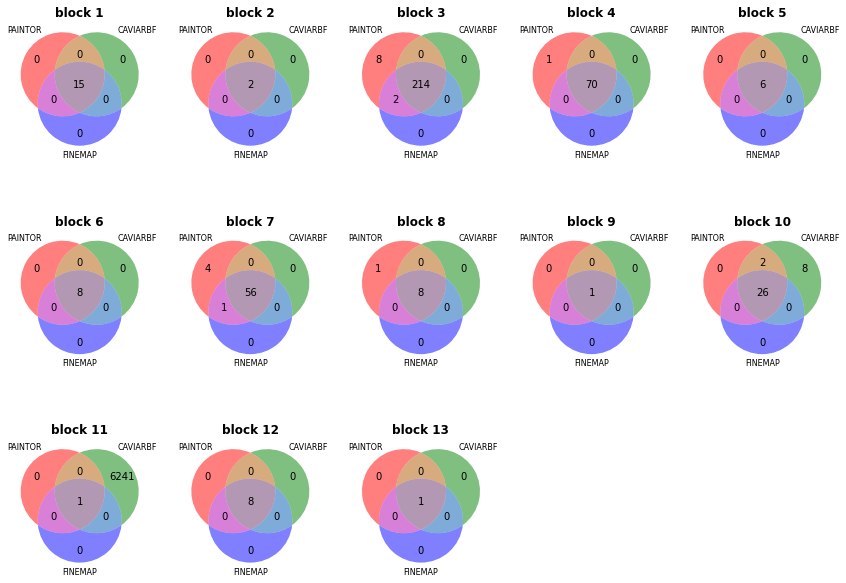

In [206]:
## Unweighted Venn diagrams of credible sets
## Unweighted to make sure each part can be seen clearly
figure, axes = plt.subplots(3, 5, figsize=(12,9))
for i in range(13):
    counts = [res[(res['cred_set'] == i+1) & (res['label'] == j)].shape[0] for j in range(1,8)]
    vd = venn3_unweighted(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], ax=axes[int(i/5)][i%5], alpha=0.5)
    for set_label in ['A','B','C']:
        vd.get_label_by_id(set_label).set_fontsize(8)
        vd.get_label_by_id(set_label).set_alpha(1)
    axes[int(i/5)][i%5].set_title("block {}".format(i+1), fontweight='bold')
figure.delaxes(axes[2][3])
figure.delaxes(axes[2][4])
# figure.suptitle('Venn diagram of credible sets for each causal block', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("venn_1.png")
plt.show()

In [242]:
def single_venn(res, i, weighted=False, fpath=None):
    ''' plot a single Venn diagram for a causal block '''
    counts = [res[(res['cred_set'] == i) & (res['label'] == j)].shape[0] for j in range(1,8)]
    if weighted:
        venn3(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], alpha=0.5)
    else:
        venn3_unweighted(subsets=counts, set_labels=['PAINTOR','CAVIARBF','FINEMAP'], alpha=0.5)
    plt.title("block {}".format(i), fontweight='bold')
    if not fpath:
        plt.savefig("images/block{}.png".format(i))
    else:
        plt.savefig(fpath)
    plt.show()

In [266]:
## Query against dbSNP to retreive annotations
mv = myvariant.MyVariantInfo()

In [360]:
# Naive search with dbSNP
# Caution: missing entries need to be verified
# Note: takes some time to run the following code
genes, annot = [np.nan]*res.shape[0], [np.nan]*res.shape[0]
for i in range(res.shape[0]):
    print(i, res.iloc[i]['rsID'])
    out = mv.query('dbsnp.rsid:{}'.format(res.iloc[i]['rsID']), fields='dbsnp')
    if len(out['hits']) == 0: continue
    if 'gene' not in out['hits'][0]['dbsnp']: continue
    if type(out['hits'][0]['dbsnp']['gene']) == dict:
        genes[i] = out['hits'][0]['dbsnp']['gene']['symbol']
        if type(out['hits'][0]['dbsnp']['gene']['rnas']) == dict:
            if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas']: continue
            so = out['hits'][0]['dbsnp']['gene']['rnas']['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
        else:
            if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas'][0]: continue
            so = out['hits'][0]['dbsnp']['gene']['rnas'][0]['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
    else:
        genes[i] = out['hits'][0]['dbsnp']['gene'][0]['symbol']
        if type(out['hits'][0]['dbsnp']['gene'][0]['rnas']) == dict:
            if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas']: continue
            so = out['hits'][0]['dbsnp']['gene'][0]['rnas']['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
        else:
            if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]: continue
            so = out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']

In [383]:
## Add to the dataframe
res['gene'] = np.array(genes)
res['annotation'] = np.array(annot)
res.head()

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,13,NECTIN2,intron_variant
433,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,11,DSG2,intron_variant
396,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,9,SORL1,intron_variant
387,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,8,nan,nan
397,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,10,SLC24A4,intron_variant


In [395]:
## Manually update some missing annotations
res.loc[(res['gene'] != 'nan') & (res['annotation'] == 'nan'), ['annotation']] = ['500B Downstream Variant', '2KB Upstream Variant', '500B Downstream Variant', '2KB Upstream Variant', '2KB Upstream Variant']

In [397]:
# save the updated file
res.to_csv("output/proc_res.txt", sep='\t', index=False)

In [21]:
# re-load the updated file
res = pd.read_csv("output/proc_res.txt", sep='\t', header=0)
print(res.shape)
res.head()

(6684, 18)


,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
0,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.000000,1.000000,1.000000,1609,7,13,NECTIN2,intron_variant
1,18,29088958,rs8093731,0.0119,T,C,-0.6136,0.1123,4.630000e-08,-5.463936,0.989497,0.934788,0.992240,1547,7,11,DSG2,intron_variant
2,11,121435587,rs11218343,0.0427,C,T,-0.2697,0.0410,4.976000e-11,-6.578049,0.983449,0.986059,0.985594,1169,7,9,SORL1,intron_variant
3,11,85867875,rs10792832,0.3718,A,G,-0.1297,0.0161,6.534000e-16,8.055901,0.582329,0.599754,0.596197,1142,7,8,NaN,NaN
4,14,92938855,rs12590654,0.3370,A,G,-0.0965,0.0176,4.097000e-08,-5.482955,0.543408,0.551195,0.560980,1369,7,10,SLC24A4,intron_variant


In [29]:
## Examine the credible set of each causal block
res[res['cred_set'] == 13]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
0,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.0,1.0,1.0,1609,7,13,NECTIN2,intron_variant


In [409]:
# column names to show
col_shown = res.columns[:-5].tolist() + res.columns[-4:].tolist()
print(col_shown)

['CHR', 'POS', 'rsID', 'MAF', 'REF', 'ALT', 'BETA', 'SE', 'P', 'Zscore', 'PAINTOR', 'CAVIARBF', 'FINEMAP', 'label', 'cred_set', 'gene', 'annotation']


In [410]:
## credible sets
res[res['cred_set'] == 13][col_shown]

,CHR,POS,rsID,MAF,REF,ALT,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,label,cred_set,gene,annotation
6683,19,45351516,rs41289512,0.0308,G,C,1.6384,0.0594,2.240000e-167,27.582492,1.0,1.0,1.0,7,13,NECTIN2,intron_variant


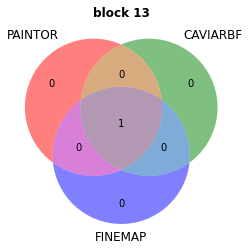

In [237]:
## venn diagram fro block 13
single_venn(res, 13)

## Results whem max_causal_variant=2

In [36]:
## Load the final results (credible sets)
res2 = pd.read_csv("output/summary_total_credible_set.txt", sep='\t', header=0)
res2 = res2.sort_values(['FINEMAP'], ascending=False)
res2['cred_set'] = -1
print(res2.shape)
res2.head(10)

(109, 16)


,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000e+00,0.000000e+00,1.000000,1609,4,-1
67,11,121451813,rs1790211,0.0159,T,G,-0.3168,0.0606,1.750000e-07,5.227723,8.318840e-06,0.000000e+00,1.000000,1169,4,-1
45,7,143095256,rs35251323,0.3171,G,A,0.0884,0.0184,1.622000e-06,4.804348,9.790850e-12,0.000000e+00,1.000000,832,4,-1
34,6,32565662,rs9270640,0.2922,A,G,-0.0903,0.0222,4.672000e-05,-4.067568,3.905520e-145,0.000000e+00,1.000000,657,4,-1
28,2,127887750,rs62158731,0.2575,T,C,-0.1189,0.0202,4.176000e-09,-5.886139,4.119830e-10,2.347334e-137,1.000000,207,4,-1
62,11,84434573,rs553071,0.2972,T,C,-0.0409,0.0169,1.554000e-02,2.420118,8.429880e-93,0.000000e+00,1.000000,1142,4,-1
74,14,92930445,rs61977311,0.2366,A,G,0.0787,0.0181,1.326000e-05,4.348066,1.279280e-09,0.000000e+00,1.000000,1369,4,-1
107,19,45365604,rs12980613,0.4095,G,A,0.1976,0.0178,1.477000e-28,11.101124,0.000000e+00,1.000000e+00,1.000000,1609,6,-1
29,2,127883899,rs7559175,0.2763,G,A,-0.1138,0.0189,1.613000e-09,6.021164,3.504520e-10,2.011547e-137,0.999936,207,4,-1
41,6,47421188,rs7774615,0.4920,A,G,-0.0747,0.0158,2.161000e-06,4.727848,2.636610e-31,0.000000e+00,0.999900,667,4,-1


In [37]:
## update credible set assignment
markers2 = []
for i in range(blocks.shape[0]):
    chr_, start, stop = blocks.iloc[i]
    # print()
    res2_sel = res2[(res2['CHR'] == chr_) & (res2['BP'] >= start) & (res2['BP'] <= stop)].sort_values(['FINEMAP'], ascending=False)
    res2.loc[(res2['CHR'] == chr_) & (res2['BP'] >= start) & (res2['BP'] <= stop), ['cred_set']] = i+1
    # res_sel
    marker = res2_sel.iloc[0]['rsID']
    # print(marker)
    markers2.append(marker)

In [38]:
# Naive search with dbSNP
# Caution: missing entries need to be verified
mv = myvariant.MyVariantInfo()
genes, annot = [np.nan]*res2.shape[0], [np.nan]*res2.shape[0]
for i in range(res2.shape[0]):
    print(i, res2.iloc[i]['rsID'])
    out = mv.query('dbsnp.rsid:{}'.format(res2.iloc[i]['rsID']), fields='dbsnp')
    if len(out['hits']) == 0: continue
    if 'gene' not in out['hits'][0]['dbsnp']: continue
    if type(out['hits'][0]['dbsnp']['gene']) == dict:
        genes[i] = out['hits'][0]['dbsnp']['gene']['symbol']
        if type(out['hits'][0]['dbsnp']['gene']['rnas']) == dict:
            if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas']: continue
            so = out['hits'][0]['dbsnp']['gene']['rnas']['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
        else:
            if 'so' not in out['hits'][0]['dbsnp']['gene']['rnas'][0]: continue
            so = out['hits'][0]['dbsnp']['gene']['rnas'][0]['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
    else:
        genes[i] = out['hits'][0]['dbsnp']['gene'][0]['symbol']
        if type(out['hits'][0]['dbsnp']['gene'][0]['rnas']) == dict:
            if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas']: continue
            so = out['hits'][0]['dbsnp']['gene'][0]['rnas']['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']
        else:
            if 'so' not in out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]: continue
            so = out['hits'][0]['dbsnp']['gene'][0]['rnas'][0]['so']
            annot[i] = so['name'] if type(so) == dict else so[0]['name']

0 rs406315
1 rs1790211
2 rs35251323
3 rs9270640
4 rs62158731
5 rs553071
6 rs61977311
7 rs12980613
8 rs7559175
9 rs7774615
10 rs2184396
11 rs9270644
12 rs718376
13 rs2162254
14 rs6464548
15 rs9331908
16 rs3098921
17 rs7946599
18 rs8086175
19 rs11234133
20 rs6661489
21 rs12151021
22 rs3752231
23 rs11787077
24 rs4147929
25 rs10898285
26 rs67027268
27 rs3993878
28 rs7982
29 rs4844577
30 rs10129711
31 rs941648
32 rs4236673
33 rs3752246
34 rs7532422
35 rs10129728
36 rs1946997
37 rs1752684
38 rs1532276
39 rs3764645
40 rs4904923
41 rs4904922
42 rs10130373
43 rs4266886
44 rs6683677
45 rs6540875
46 rs6673080
47 rs61821051
48 rs61821050
49 rs4844579
50 rs78410552
51 rs6540874
52 rs7515905
53 rs57003024
54 rs12119823
55 rs4844574
56 rs2070926
57 rs679515
58 rs4147911
59 rs4147910
60 rs374881486
61 rs8093731
62 rs2796250
63 rs2796251
64 rs3997874
65 rs111278892
66 rs1968456
67 rs75364577
68 rs8111988
69 rs28659974
70 rs115116587
71 rs4147920
72 rs374154683
73 rs116694119
74 rs73414289
75 rs10417324

In [39]:
## update annotations in the dataframe
res2['gene'] = np.array(genes)
res2['annotation'] = np.array(annot)
res2.head()

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000e+00,0.000000e+00,1.0,1609,4,13,NECTIN2,intron_variant
67,11,121451813,rs1790211,0.0159,T,G,-0.3168,0.0606,1.750000e-07,5.227723,8.318840e-06,0.000000e+00,1.0,1169,4,9,SORL1,intron_variant
45,7,143095256,rs35251323,0.3171,G,A,0.0884,0.0184,1.622000e-06,4.804348,9.790850e-12,0.000000e+00,1.0,832,4,5,EPHA1,intron_variant
34,6,32565662,rs9270640,0.2922,A,G,-0.0903,0.0222,4.672000e-05,-4.067568,3.905520e-145,0.000000e+00,1.0,657,4,3,nan,nan
28,2,127887750,rs62158731,0.2575,T,C,-0.1189,0.0202,4.176000e-09,-5.886139,4.119830e-10,2.347334e-137,1.0,207,4,2,LOC105373605,intron_variant


In [60]:
# Examine the credible set in each causal block
res2[res2['cred_set'] == 13]

,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000,0.0,1.000000e+00,1609,4,13,NECTIN2,intron_variant
107,19,45365604,rs12980613,0.4095,G,A,0.1976,0.0178,1.477000e-28,11.101124,0.000000,1.0,1.000000e+00,1609,6,13,NECTIN2,intron_variant
106,19,45361960,rs417193,0.4095,C,T,0.1103,0.0169,7.057000e-11,6.526627,0.000000,1.0,1.066760e-266,1609,2,13,NECTIN2,intron_variant
104,19,45395266,rs157580,0.3757,G,A,-0.3779,0.0177,1.210000e-101,21.350282,1.000000,0.0,0.000000e+00,1609,1,13,TOMM40,intron_variant
105,19,45404431,rs741780,0.4483,C,T,-0.4104,0.0171,2.290000e-127,-24.000000,0.996771,0.0,0.000000e+00,1609,1,13,TOMM40,intron_variant


In [13]:
# have a look at those variants with no genes/annotations available
res2_mis = res2[(res2['gene'] == 'nan') | (res2['annotation'] != 'nan')]
print(res2_mis.shape)
res2_mis

(109, 18)


,CHR,BP,rsID,MAF,EA,NEA,BETA,SE,P,Zscore,PAINTOR,CAVIARBF,FINEMAP,block_id,label,cred_set,gene,annotation
108,19,45384116,rs406315,0.3956,G,A,0.2688,0.0177,5.481000e-52,-15.186441,0.000000e+00,0.000000e+00,1.000000e+00,1609,4,12,NECTIN2,intron_variant
67,11,121451813,rs1790211,0.0159,T,G,-0.3168,0.0606,1.750000e-07,5.227723,8.318840e-06,0.000000e+00,1.000000e+00,1169,4,8,SORL1,intron_variant
45,7,143095256,rs35251323,0.3171,G,A,0.0884,0.0184,1.622000e-06,4.804348,9.790850e-12,0.000000e+00,1.000000e+00,832,4,4,EPHA1,intron_variant
34,6,32565662,rs9270640,0.2922,A,G,-0.0903,0.0222,4.672000e-05,-4.067568,3.905520e-145,0.000000e+00,1.000000e+00,657,4,2,nan,nan
28,2,127887750,rs62158731,0.2575,T,C,-0.1189,0.0202,4.176000e-09,-5.886139,4.119830e-10,2.347334e-137,1.000000e+00,207,4,1,LOC105373605,intron_variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,19,45361960,rs417193,0.4095,C,T,0.1103,0.0169,7.057000e-11,6.526627,0.000000e+00,1.000000e+00,1.066760e-266,1609,2,12,NECTIN2,intron_variant
56,11,59388596,rs112268927,0.0089,C,G,0.2462,0.0909,6.764000e-03,2.708471,9.999150e-01,1.000000e+00,2.194250e-310,1129,3,6,LOC101927226,intron_variant
57,11,59494180,rs2447309,0.0089,C,G,-0.0475,0.1210,6.950000e-01,-0.392562,9.999150e-01,1.000000e+00,4.479810e-312,1129,3,6,nan,nan
104,19,45395266,rs157580,0.3757,G,A,-0.3779,0.0177,1.210000e-101,21.350282,1.000000e+00,0.000000e+00,0.000000e+00,1609,1,12,TOMM40,intron_variant


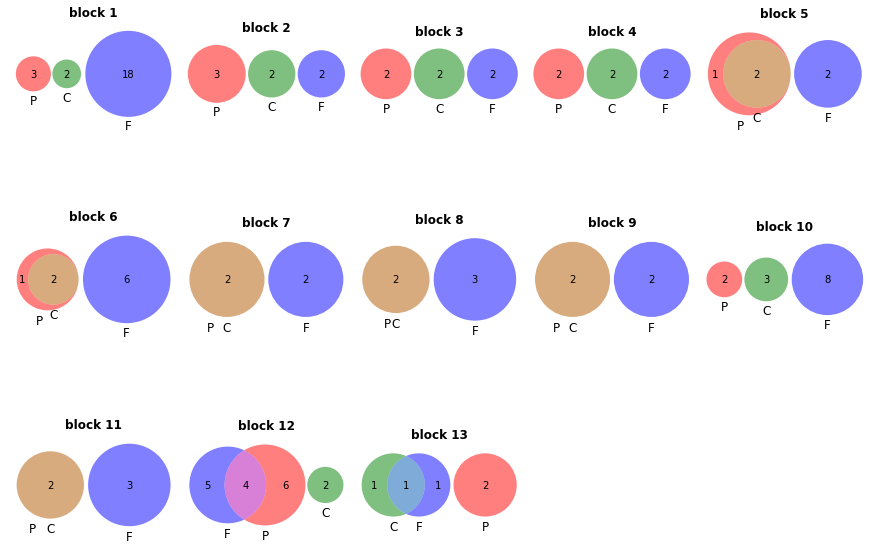

In [205]:
## (Weighted) Venn diagrams of credible sets at each causal block
figure, axes = plt.subplots(3, 5, figsize=(12,9))
for i in range(13):
    counts = [res2[(res2['cred_set'] == i) & (res2['label'] == j)].shape[0] for j in range(1,8)]
    vd = venn3(subsets=counts, set_labels=['P','C','F'], ax=axes[int(i/5)][i%5], alpha=0.5)
    if i == 4: vd.get_label_by_id('A').set_x(-0.35)
    if i == 5: vd.get_label_by_id('A').set_x(-0.55)
    if i in [6,7,8]: vd.get_label_by_id('A').set_x(-0.45)
    if i == 10: vd.get_label_by_id('A').set_x(-0.55)
    axes[int(i/5)][i%5].set_title("block {}".format(i+1), fontweight='bold')
figure.delaxes(axes[2][3])
figure.delaxes(axes[2][4])
# figure.suptitle('Venn diagram of credible sets for each causal block', fontsize=16, fontweight='bold')
plt.tight_layout(pad=0)
plt.savefig("venn_2.png")
plt.show()

In [41]:
# save the updated file
res2.to_csv("output/proc_res2.txt", sep='\t', index=False)